# How to: Hyperparameter Tuning with Keras + Sklearn GridSearchCV
- James M. Irving
- Updated 10/03/2019

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#How-to:-Hyperparameter-Tuning-with-Keras-+-Sklearn-GridSearchCV" data-toc-modified-id="How-to:-Hyperparameter-Tuning-with-Keras-+-Sklearn-GridSearchCV-1">How to: Hyperparameter Tuning with Keras + Sklearn GridSearchCV</a></span><ul class="toc-item"><li><span><a href="#NOTE-/-WARNING:" data-toc-modified-id="NOTE-/-WARNING:-1.1">NOTE / WARNING:</a></span></li><li><span><a href="#HOW-TO:-GridSearch-with-Keras" data-toc-modified-id="HOW-TO:-GridSearch-with-Keras-1.2">HOW TO: GridSearch with Keras</a></span></li><li><span><a href="#HOW-TO:-Custom-Scoring-Functions" data-toc-modified-id="HOW-TO:-Custom-Scoring-Functions-1.3">HOW TO: Custom Scoring Functions</a></span><ul class="toc-item"><li><span><a href="#def-my_custom_scorer" data-toc-modified-id="def-my_custom_scorer-1.3.1">def my_custom_scorer</a></span></li></ul></li></ul></li><li><span><a href="#HOW-TO:-Adding-Email-Notifications-with-Encrypted-Passwords" data-toc-modified-id="HOW-TO:-Adding-Email-Notifications-with-Encrypted-Passwords-2">HOW TO: Adding Email Notifications with Encrypted Passwords</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#def-email_notification" data-toc-modified-id="def-email_notification-2.0.1">def email_notification</a></span></li></ul></li></ul></li><li><span><a href="#EXAMPLE-USAGE" data-toc-modified-id="EXAMPLE-USAGE-3">EXAMPLE USAGE</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-3.1">Load data</a></span></li><li><span><a href="#Tokenize-and-train/test/val-split" data-toc-modified-id="Tokenize-and-train/test/val-split-3.2">Tokenize and train/test/val split</a></span></li><li><span><a href="#EXAMPLE---USING-GRIDSEARCH-DIRECTLY" data-toc-modified-id="EXAMPLE---USING-GRIDSEARCH-DIRECTLY-3.3">EXAMPLE - USING GRIDSEARCH DIRECTLY</a></span></li><li><span><a href="#EXAMPLE-USAGE-AS-A-FUNCTION" data-toc-modified-id="EXAMPLE-USAGE-AS-A-FUNCTION-3.4">EXAMPLE USAGE AS A FUNCTION</a></span></li><li><span><a href="#Companion/Follow-up-Function-for-Running-Best-Params-from-fit_gridsearch" data-toc-modified-id="Companion/Follow-up-Function-for-Running-Best-Params-from-fit_gridsearch-3.5">Companion/Follow-up Function for Running Best Params from <code>fit_gridsearch</code></a></span></li></ul></li></ul></div>

## NOTE / WARNING:
> **I use my custom package `bs_ds` in this notebook.** <br><br>
> bs_ds installs **Cufflinks with Plotly** to make ***super easy*** Plotly figures.<br>
`>> df.iplot(kind='bar')`

> But this means it **requires the OLDER v3** of PLotly (V3.10) <br>
> ***[!] If you install bs_ds it may overwrite your Plotly v4.***<br>
- You can simply run`!pip install -U plotly` again to restore it.

> **P.S. Cufflinks is TOTALLY worth it**, if you aren't reliant on Plotly v4.
- To Learn About Cufflinks:
    - http://web.quant-platform.com/trial/yves/Plotly_Cufflinks.html
- To use cufflinks:<br>
`import cufflinks as cf
cf.go_offline()
` 
- Thats it! Now there is a new `.iplot()` method on pandas dataframes.


**`Uncomment the cell below to install/update bs_ds`**

In [1]:
## Uncomment to install / update bs_ds. (read note below first)
#!pip install -U bs_ds

In [2]:
## IMPORT CUSTOM CAPSTONE FUNCTIONS
import functions_combined_BEST as ji
from functions_combined_BEST import ihelp, ihelp_menu,\
reload, inspect_variables

import warnings
warnings.filterwarnings('ignore')
## IMPORT MY PUBLISHED PYPI PACKAGE 
from bs_ds.imports import *

bs_ds  v0.9.12 loaded.  Read the docs: https://bs-ds.readthedocs.io/en/latest/index.html
For convenient loading of standard modules use: from bs_ds.imports import *



Package,Handle,Description
bs_ds,bs,Custom data science bootcamp student package
matplotlib,mpl,Matplotlib's base OOP module with formatting artists
matplotlib.pyplot,plt,Matplotlib's matlab-like plotting module
numpy,np,scientific computing with Python
pandas,pd,High performance data structures and tools
seaborn,sns,High-level data visualization library based on matplotlib


## HOW TO: GridSearch with Keras


Original Source: https://chrisalbon.com/deep_learning/keras/tuning_neural_network_hyperparameters/
<br><br>

- To use `GridSearchCV` or other similar functions in scikit-learn with a Keras neural network, we need to wrap our keras model in `keras.wrappers.scikit_learn`'s `KerasClassifier` and `KerasRegressor`.
1. To do this, we need to write a build function(`build_fn`) that creates our model such as `create_model`.
    - This function must accept whatever parameters you wish to tune. 
    - It also must have a default argument for each parameter.
    - This function must Return the model (and only the model)
    
```python

## Define the build function
def create_model(n_units=(50,25,7), activation='relu',final_activation='softmax',
                optimizer='adam'):
    
    ## Pro tip:save the local variables now so you can print out the parameters used to create the model.
    params_used = locals()
    print('Parameters for model:\n',params_used)
    
   
    from keras.models import Sequential
    from keras import layers
    
    model=Sequential()
    model.add(layers.Dense(n_units[0], activation=activation, input_shape=(2000,)))
    model.add(layers.Dense(n_units[1], activation=activation))
    model.add(layers.Dense(n_units[2], activation=final_activation))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    
    display(model.summary())
    return model 
```    

2. We then create out model using the Keras wrapper:

```python
from keras.wrappers.scikit_learn import KerasClassifier
neural_network =  KerasClassifier(build_fn=create_model,verbose=1)
```

3. Now, set up the hyperparameter space for grid search. (Remember, your `create_model` function must accept the parameter you want to tune)

```python
params_to_test = {'n_units':[(50,25,7),(100,50,7)],
                  'optimizer':['adam','rmsprop','adadelta'],
                  'activation':['linear','relu','tanh'],
                  'final_activation':['softmax']}
```

4. Now instantiate your GridSearch function

```python
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=neural_network,param_grid=params_to_test)
grid_result = grid.fit(X_train, y_train)
best_params = grid_result.best_params_
```
5. And thats it!


## HOW TO: Custom Scoring Functions

1. **Why would you do this?**
    1. You may want to use a metric that isn't available in sklearn. 
        - In the included `my_custom_scorer` function, I take the accuracy of each class's predictions from the diagonal of a normalized confusion matrix. 
        - I then calculate the mean of those 3 class accuracies, which is the `score` that is returned to the gridsearch. 
        
    2. You may want to add a printout or display to the scoring function so you can see the results as the search is going.
<br><br>
2. **How do you do write your own?**
    1. Define your custom scoring function.
        - It must accept `y_true`,`y_pred`
        - It must return a value to maximize. (like accuracy)
    2. You can add print or display commands to have the scoring function report the current results as the gridsearch is still going.
        - If you combine this with the example `create_model` function above that includes the `vars=locals(); print(vars)` command, then gridsearch will display:
            1. the parameters of each model (each time the `create_model` function is called.
            2. The score of each model, including a confusion matrix figure (each time it calls `my_custom_scorer`).
        
```python
def my_custom_scorer(y_true,y_pred):
    """My custom score function to use with sklearn's GridSearchCV
    Maximizes the average accuracy per class using a normalized confusion matrix"""
    from sklearn.metrics import confusion_matrix
    import numpy as np
    import functions_combined_BEST as ji    

    ## Flatten one-hot encoded target columns into 1 column for sklearn functions
    if y_true.ndim>1 or y_pred.ndim>1:
        
        ## reduce dimensions of y_train and y_test
        if y_true.ndim>1:            
            y_true = y_true.argmax(axis=1)
        
        if y_pred.ndim>1:
            y_pred = y_pred.argmax(axis=1)

    
     # Get confusion matrx
    cm = confusion_matrix(y_true, y_pred)

    # Normalize confusion matrix
    cm_norm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

    ## Get diagonals for class accuracy
    diag = cm_norm.diagonal()
    
    # Get the mean of the diagonal values
    score = np.mean(diag)
    
    ## Display Results for the User
    print(f'Mean Class Accuracy = {score}')
    print(f'Class Accuracy Values:')
    print(diag)    

    ## Plot the confusion matrix.
    ji.plot_confusion_matrix(cm,normalize=True)

    # return the score 
    return score
```        
        
        
3. **How do you use it?**
    - When instantiating GridSearchCV pass your function as the `scoring=` parameter, wrapped in the  `sklearn.metrics.make_scorer` function.
  

```python
## Using custom scoring function
from sklearn.metrics import make_scorer

grid = GridSearchCV(estimator=neural_network, 
                    param_grid=params_to_test,
                   scoring=make_scorer(my_custom_scorer))
                    
grid_result = grid.fit(X_train, y_train)
```

### def my_custom_scorer

In [3]:
def my_custom_scorer(y_true,y_pred):
    """My custom score function to use with sklearn's GridSearchCV
    Maximizes the average accuracy per class using a normalized confusion matrix
    [i] Note: To use my_custom_scorer in GridSearch:
    >> from sklearn.metrics import make_scorer
    >> grid = GridSearch(estimator, parameter_grid)
    """
    from sklearn.metrics import make_scorer,confusion_matrix
    import numpy as np
    import functions_combined_BEST as ji    

    # set labels for confusion matrix
    labels = ['Decrease','No Change', 'Increase']

    
    ## If y_true is a multi-column one-hotted target
    if y_true.ndim>1 or y_pred.ndim>1:

        ## reduce dimensions of y_train and y_test
        if y_true.ndim>1:            
            y_true = y_true.argmax(axis=1)
            
        if y_pred.ndim>1:
            y_pred = y_pred.argmax(axis=1)

    
    ## Get confusion matrx
    cm = confusion_matrix(y_true, y_pred)

    ## Normalize confusion matrix
    cm_norm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

    ## Get diagonals for class accuracy
    diag = cm_norm.diagonal()
    score = np.mean(diag)
    
    
    ## Display results for user
    print(f'Mean Class Accuracy = {score}')
    print(f'Class Accuracy Values:')
    print(diag)    

    ## Plot confusion matrix
    ji.plot_confusion_matrix(cm,normalize=True,classes=labels);

    return score

In [4]:
ji.ihelp_menu2([ji.plot_confusion_matrix])

GridBox(box_style='warning', children=(VBox(children=(Label(value='iHelp Menu: View Help and/or Source Code'),…

Output()

# HOW TO: Adding Email Notifications with Encrypted Passwords

Original Source/Inspiration: https://www.mssqltips.com/sqlservertip/5173/encrypting-passwords-for-use-with-python-and-sql-server/

In [5]:
class EncryptedPassword():
    """Class that can be used to either provide a password/username to be encrypted 
    OR to load a previously encypted password from file.    
    NOTE: Once you have encrypted your password and saved to bin files, you do not need to provide the password again. 
    Make sure to delete your password from the notebook after. 
    - If encrypting a password, a key file and a password file will be saved to disk. 
        - Default Key Filename: '..\\encryption_key.bin',
        - Default Password Filename: '..\\encrypted_pwd.bin'
        - Default Username Filename: '..\\encrypted_username.bin'
    
    The string representations of the unencrypted password are shielded from displaying, when possible. 
    


    - If opening and decrypting key and password files, pass filenames during initialization. 
    
    
    Example Usage:
    >> # To Encrypt, with default folders:
    >> my_pwd EncryptedPassword('my_password')
    
    >> # To Encrypt With custom folders
    >> my_pwd = EncryptedPassword('my_password',filename_for_key='..\folder_outside_repo\key.bin',
                                    filename_for_password = '..\folder_outside_repo\key.bin')
                                    
                                    
    >> # To open and decrypt files (from default folders):
    >> my_pwd = EncryptedPassword(from_file=True)
    
    >> # To open and decrypt files (from custom folders):
    >> my_pwd = EncryptedPassword(from_file=True, 
                                filename_for_key='..\folder_outside_repo\key.bin',
                                filename_for_password = '..\folder_outside_repo\key.bin')
                                    
        
    """
    
    ## Default username
    username = 'NOT PROVIDED'
    
    ## the .password property is designed so it will not display an unencrypted password. 
    @property ## password getter 
    def password(self):
        # if the encrypyted password already exists, print the encrypted pwd (unusable without key)
        if hasattr(self,'_encrypted_password_'):
            print('Encrypted Password:')
            return self._encrypted_password_
        else:
            raise Exception('Password not yet encrypted.')
    
    ## the .password property cannot be set by a user
    @password.setter ## password setter
    def password(self,password):
        raise Exception('.password is read only.')
        
               
    ## 
    def __init__(self,username=None,password=None,from_file=False, encrypt=True,
                filename_for_key='..\\encryption_key.bin',
                filename_for_password='..\\encrypted_pwd.bin',
                filename_for_username = '..\\encrypted_username.bin'):
        """Accepts either a username and password to encyrypt, 
        or loads a previously encrypyed password from file.
        
        Args:
            username (str): email username.
            password (str): email password (note: if have 2-factor authentication on email account, 
                will need app-specific password).
            from_file (bool): whether to load the user credentials from file
            encrypt (bool): whether to encrypt provided password. Default=True
            
            filename_for_key (str): filepath for key.bin (default is'..\\encryption_key.bin')
            filename_for_password: filepath for password.bin (default is'..\\encryption_pwd.bin')
            filename_for_username: filepath for username.bin (default is'..\\encrypted_username.bin')
            """
        
        ## Save filenames 
        self.filename_for_key = filename_for_key
        self.filename_for_password = filename_for_password
        self.filename_for_username = filename_for_username
        
        ## If user passed a username, set username
        if username is not None:
            self.username = username
        
        ## If no password is provided:
        if (password is None):
            
            ##  if load from file if `from_file`=True
            if (from_file==True):
                
                try: ## Load in the key, password, username files
                    self.load_from_file(key_filename=filename_for_key,
                                    password_filename=filename_for_password,
                                        username_filename=filename_for_username)
                except:
                    raise Exception('Something went wrong. Do the key and password files exist?')
            
            ## If no password provided, and from_file=False, raise error
            else:
                raise Exception('Must either provide a password to encrypt, or set from_file=True')
        
        
        ## If the user DOES provide a password
        else:
            self._password_ = password # set the private attribute for password
            
            ## Encrypt the password
            if encrypt:
                self.encrypt_password()
                
                
    def encrypt_password(self, show_encrypted_password=False):
        """Encrypt the key, username, and password and save to external files."""
         ## Get filenames to use.
        filename_for_key= self.filename_for_key
        filename_for_password=self.filename_for_password
        filename_for_username = self.filename_for_username

        ## Import cryptography and generate encryption key
        from cryptography.fernet import Fernet
        key = Fernet.generate_key()
        self._key_ = key

        ## Create the cipher_suit from key for encrypting/decrypting
        cipher_suite = Fernet(key)
        self._cipher_suite_ = cipher_suite
 
        ## ENCRYPT PASSWORD
        # Get password and change to byte encoding
        password = self._password_
        password_to_encrypt = bytes(password,'utf-8') #password must be in bytes format
        
        # Use the encryption suite to encrypt the password and save to self
        ciphered_pwd = cipher_suite.encrypt(password_to_encrypt)
        self._encrypted_password_ = bytes(ciphered_pwd).decode('utf-8')
        
        # Print encrypyted password if true
        if show_encrypted_password:
            print('Encrypyted Password:')
            print(self._encrypted_password_)
        
        
        ## ENCRYPT USERNAME
        username = self.username
        username_to_encrypt = bytes(username,'utf-8')
        ciphered_username = cipher_suite.encrypt(username_to_encrypt)
        self._encrypted_username_ = bytes(ciphered_username).decode('utf-8')
        
        ## TEST DECRYPTION
        # decrypt password and username
        unciphered_pwd = cipher_suite.decrypt(ciphered_pwd)
        unciphered_username = cipher_suite.decrypt(ciphered_username)
        
        ## Decode from bytes to utf-8
        password_decoded = unciphered_pwd.decode('utf-8')
        username_decoded = unciphered_username.decode('utf-8')
        
        # Check if decoded text matches input text
        check_pwd = password_decoded==password
        check_user = username_decoded==username
        
        ## If everything matches, warn user to delete their exposed password
        if  check_pwd & check_user:
            self._password_ = password_decoded 
            print('[!] Make sure to delete typed password above from class instantiation.')
        else:
            raise Exception('Decrypted password and input password/username do not match. Something went wrong.')

        ## SAVE KEY, PASSWORD, AND USERNAME TO BIN FILES
        ## Specify binary files (outside of repo) for storing key and password files
        with open(filename_for_key,'wb') as file:
            file.write(key)

        with open(filename_for_password,'wb') as file:
            file.write(ciphered_pwd)
            
        with open(filename_for_username,'wb') as file:
            file.write(ciphered_username)

        # Display filepaths for user.
        print(f'[io] Encryption Key saved as {filename_for_key}')
        print(f'[io] Encrypted Password saved as {filename_for_password}')
        print(f'[io] Encrypted Username saved as {filename_for_username}')

            
    
    def load_from_file(self,key_filename,password_filename,
                      username_filename):
        """Load in the encrypted password from file. """
        
        from cryptography.fernet import Fernet
        
        ## Load Key 
        with open(key_filename,'rb') as file:
            for line in file:
                key = line

        ## Make ciphere suite from key
        cipher_suite = Fernet(key)
        self._cipher_suite_ = cipher_suite

        ## Load password
        with open(password_filename,'rb') as file:
            for line in file:
                encryptedpwd = line
        self._encrypted_password_ = encryptedpwd
        
        ## Decrypt password
        unciphered_text = (cipher_suite.decrypt(encryptedpwd))
        plain_text_encrypted_password = bytes(unciphered_text).decode('utf-8')
        self._password_ = plain_text_encrypted_password
        
        ## Load username
        with open(username_filename,'rb') as file:
            for line in file:
                username = line
        unciphered_username = (cipher_suite.decrypt(username))
        plan_text_username = bytes(unciphered_username).decode('utf-8')
        self.username = plan_text_username
        
    def __repr__(self):
        """Controls the printout when the object is the final command in a cell.
        i.e:
        >> pwd =EncrypytedPassword(username='me',password='secret')
        >> pwd
        """
        password = self._password_
        msg = f'[i] Password is {len(password)} chars long.'
        return msg

    def __str__(self):
        """Controls the printout when the object is printed.
        i.e:
        >> pwd =EncrypytedPassword(username='me',password='secret')
        >> print(pwd)
        """
        password = self._password_
        msg = f'[i] Password is {len(password)} chars long.'
        return msg 

In [6]:
## Create EncrypyedPassword object (only need to do this step 1 time from any notebook in the repo)
# enc_pwd = EncryptedPassword(username='james.irving.phd@gmail.com',password='')

## note: to be extra safe, i'm loading in the raw password from an external text file
with open('../encrypt_me.txt') as f: raw_text_pwd=f.read() 
    
# I might forget to delete it before sharing this if i typed it lol
enc_pwd = EncryptedPassword(username='james.irving.phd@gmail.com',password=raw_text_pwd)

[!] Make sure to delete typed password above from class instantiation.
[io] Encryption Key saved as ..\encryption_key.bin
[io] Encrypted Password saved as ..\encrypted_pwd.bin
[io] Encrypted Username saved as ..\encrypted_username.bin


In [7]:
## If using the default file locations, this is all you need to load in encrypted data
loaded_pwd = EncryptedPassword(from_file=True)
loaded_pwd

[i] Password is 16 chars long.

In [8]:
## Can access raw username
loaded_pwd.username

'james.irving.phd@gmail.com'

In [9]:
## Cannot directly access decrypted password
loaded_pwd.password

# The Encrypted Password printed below can only be used if decoded using the original cipher key. 
# Since the key file is stored OUTSIDE the repo, the output is harmless if you were to leave it in your notebook. 

Encrypted Password:


b'gAAAAABdlp8nZ5jSpz4QAgGYbWERBxELMUpVbPOUC4BlT7YZLjTR8DJCLpaQNdmarnEJrRAYtqHHw4pkxSA9i6zpBJnUNcf1SDDTQRzfVtrHfaf5YCLK6ns='

### def email_notification

In [10]:
def email_notification(password_obj=None,subject='GridSearch Finished',msg='The GridSearch is now complete.'):
    """Sends email notification from gmail account using previously encrypyted password  object (an instance
    of EncrypytedPassword). 
    Args:
        password_obj (EncryptedPassword object): EncryptedPassword object with username/password.
        subject (str):Text for subject line.
        msg (str): Text for body of email. 

    Returns:
        Prints `Email sent!` if email successful. 
    """
    ## Display instructions if no password_obj 
    if password_obj is None:
        print('Must pass an EncrypytedPassword object.')
        print('>> pwd_obj = EncryptedPassword(username="my_username",password="my_password")')
        print('>> send_email(encrypted_password_obj=pwd_obj)')
        raise Exception('Must pass an EncryptedPassword.')
    
    # import required packages
    import smtplib
    from email.mime.multipart import MIMEMultipart
    from email.mime.text import MIMEText
    from email import encoders
    
    ## Get username and password from password_obj
    gmail_user = password_obj.username
    gmail_password = password_obj._password_
    
    ## WRITE EMAIL
    message = MIMEMultipart()
    message['Subject'] =subject
    message['To'] = gmail_user
    message['From'] = gmail_user
    body = msg
    message.attach(MIMEText(body,'plain'))
    text_message = message.as_string()


    # Send email request
    try:
        with  smtplib.SMTP_SSL('smtp.gmail.com',465) as server:
            
            server.login(gmail_user,gmail_password)
            server.sendmail(gmail_user,gmail_user, text_message)
            server.close()
            print('Email sent!')
        
    except Exception as e:
        print(e)
        print('Something went wrong')

In [11]:
email_notification(loaded_pwd)

Email sent!


# EXAMPLE USAGE

## Load data

In [12]:
df_sampled = pd.read_csv('shared_memory/df_sampled_test_nlp_models.csv',index_col=0,parse_dates=True)
df_sampled.dropna(inplace=True)
df_sampled.head()

,delta_price_class,delta_price,pre_tweet_price,post_tweet_price,delta_time,B_ts_rounded,B_ts_post_tweet,content,content_min_clean,cleaned_stopped_content,cleaned_stopped_tokens,cleaned_stopped_lemmas,delta_price_class_int
date,,,,,,,,,,,,,
2019-08-23 14:59:04,neg,-0.49,112.77,112.28,0 days 01:00:00.000000000,2019-08-23 14:59:00,2019-08-23 15:59:00,....your companies HOME and making your produc...,your companies home and making your produc...,companies home making products usa responding ...,"['companies', 'home', 'making', 'products', 'u...",company home making product usa responding chi...,0
2019-08-23 14:59:04,neg,-0.49,112.77,112.28,0 days 01:00:00.000000000,2019-08-23 14:59:00,2019-08-23 15:59:00,....better off without them. The vast amounts ...,better off without them the vast amounts ...,better without vast amounts money made stolen ...,"['better', 'without', 'vast', 'amounts', 'mone...",better without vast amount money made stolen c...,0
2019-08-23 14:57:40,neg,-0.78,112.74,111.96,0 days 01:00:00.000000000,2019-08-23 14:58:00,2019-08-23 15:58:00,....My only question is who is our bigger enem...,my only question is who is our bigger enem...,question bigger enemy jay powell chairman xi,"['question', 'bigger', 'enemy', 'jay', 'powell...",question bigger enemy jay powell chairman xi,0
2019-08-23 14:57:40,neg,-0.78,112.74,111.96,0 days 01:00:00.000000000,2019-08-23 14:58:00,2019-08-23 15:58:00,As usual the Fed did NOTHING! It is incredible...,as usual the fed did nothing it is incredible...,usual fed nothing incredible speak without kno...,"['usual', 'fed', 'nothing', 'incredible', 'spe...",usual fed nothing incredible speak without kno...,0
2019-08-23 14:57:40,neg,-0.78,112.74,111.96,0 days 01:00:00.000000000,2019-08-23 14:58:00,2019-08-23 15:58:00,....My only question is who is our bigger enem...,my only question is who is our bigger enem...,question bigger enemy jay powell chairman xi,"['question', 'bigger', 'enemy', 'jay', 'powell...",question bigger enemy jay powell chairman xi,0


In [13]:
# def load_glove_embedding_layer(fp=None, trainable=False):
#     if fp is None:
#         fp = r'D:\Users\James\Dropbox (Personal)\CODING\DATASETS\embeddings\glove.twitter.27B.100d.txt'

#     ## Make GloVe embedding matrix
#     word2index, embedding_matrix_gl = ji.load_glove_embeddings(fp=fp,encoding='utf-8',embedding_dim=100)
#     print(f'gl:\n\tshape={embedding_matrix_gl.shape}')

#     from keras import layers         
#     vocab_size = embedding_matrix_gl.shape[0]#len(wv.vocab)
#     vector_size = embedding_matrix_gl.shape[1]#wv.vector_size

#     embedding_layer_gl =layers.Embedding(vocab_size,#+1,
#                                       vector_size,
#                                       input_length=X_train.shape[1],
#                                       weights=[embedding_matrix_gl],
#                                       trainable=trainable)
#     return word2index, embedding_layer_gl

# ## Load in GloVe Vectors for Embedding Layer
# glove_word2index, embedding_layer_gl = load_glove_embedding_layer(trainable=False)

## Tokenize and train/test/val split

In [14]:
## Load in word2vec if want to use for embedding layer
word2vec = ji.load_word2vec('models/word2vec/word2vec_model.pkl')
wv = word2vec.wv

[i] Loading Word2Vec model from models/word2vec/word2vec_model.pkl


In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.utils import to_categorical

## Specify text data series
text_data = df_sampled['cleaned_stopped_lemmas']

# Changed for class imblanace  #
y = to_categorical(df_sampled['delta_price_class_int'],num_classes=3)
print(f'y.shape={y.shape}')

## Instantiate and fit Tokenizer
tokenizer = Tokenizer(num_words=len(wv.vocab))
tokenizer.fit_on_texts(text_data)

# return integer-encoded sentences
X = tokenizer.texts_to_sequences(text_data)
X = sequence.pad_sequences(X)

MAX_SEQUENCE_LENGTH = X.shape[1]
print(f'Sequence length: {MAX_SEQUENCE_LENGTH}')

## Save word indices
word_index = tokenizer.index_word
reverse_index = {v:k for k,v in word_index.items()}

Using TensorFlow backend.


y.shape=(2670, 3)
Sequence length: 33


In [16]:
## Get training/test split
X_train, X_test,X_val, y_train, y_test,y_val = ji.train_test_val_split(X, y, test_size=0.15, val_size=0.15)

# ji.check_y_class_balance(data=[y_train,y_test])
print('Training Data:')
print(X_train.shape, y_train.shape)
print('Test Data:')
print(X_test.shape, y_test.shape)
print('Val Data:')
print(X_val.shape, y_val.shape)

Training Data:
(1869, 33) (1869, 3)
Test Data:
(400, 33) (400, 3)
Val Data:
(401, 33) (401, 3)


In [17]:
## Make embedding layer from word2vec
embedding_layer = ji.make_keras_embedding_layer(word2vec_model=word2vec,X_sequences=X)

embedding_matrix.shape = (4682, 300)


## EXAMPLE - USING GRIDSEARCH DIRECTLY
1. define build function
2. Create model with `KerasClassifier` or `KerasRegressor`
3. Create and fit GridSearch 

In [18]:
## A Note regarding varaible scope:

    # * Notice how I set `MAX_SEQUENCE_LENGTH = X_train.shape[1]` INSIDE the function
    # but  but i do not pass X_train as an argument. 
    
    # * Because you are defining your model INSIDE The notebook, 
    # it has access to the variables outside of it. 
    
    # THIS WOULD NOT WORK IF YOU IMPORTED `CREATE_MODEL` FROM AN EXTERNAL FILE.
    
def create_model(embedding_layer=embedding_layer,trainable=False,
              n_filters=128, filter_size=4,
              activation='relu', optimizer='rmsprop',
              dropout=0.2,l2_lr=0.01,
              batch_size=100,
              epochs=10,verbose = 1,show_summary=False):
    
    ## Print out parameters used to create model for user
    vars = locals()
    print(vars)    

    dashes = '---'*30
    print('\n\n')
    print(dashes)
    now = pd.datetime.now()
    print(now.strftime('%m/%d/%Y-%T'))
    
    
    ## Create network architetcture
    from keras.layers import Input, Conv1D,GlobalMaxPooling1D, MaxPooling1D, Dense, Dropout
    from keras.models import Model
    from keras.regularizers import l2

    print('Training model.')
    MAX_SEQUENCE_LENGTH = X_train.shape[1]

    
    ## Get Input sequences from embedding_layer
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    ## Specify layer parameters


    ## Conv Layer 1
    x = Conv1D(n_filters, filter_size, activation=activation, data_format='channels_first',
               kernel_regularizer=l2(l2_lr), bias_regularizer=l2(l2_lr))(embedded_sequences)
    x = Dropout(dropout)(x)
    x = MaxPooling1D(filter_size)(x)
    
    
    ## Conv Layer 2
    x = Conv1D(n_filters, filter_size, activation=activation,data_format='channels_first',
              kernel_regularizer=l2(l2_lr), bias_regularizer=l2(l2_lr))(x) 
    x = Dropout(dropout)(x)
    x = MaxPooling1D(filter_size)(x)
    
    
    ## Conv Layer 3
    x = Conv1D(n_filters, filter_size, activation=activation,data_format='channels_first',
              kernel_regularizer=l2(l2_lr), bias_regularizer=l2(l2_lr))(x) 
    x = Dropout(dropout)(x)
    x = GlobalMaxPooling1D()(x)
    
    
    ## Classification Layer
    x = Dense(n_filters, activation=activation )(x) #128'relu'
    preds = Dense(3, activation='softmax')(x)

    
    ## Create and compile model 
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, #'rmsprop',#adam
                  metrics=['acc'])
    
    if show_summary:
        display(model.summary())
    return model

In [19]:
## Wrapping the model in the `KerasClassifier` wrapper
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

## Wrap create_model with KerasClassifier
neural_network = KerasClassifier(build_fn=create_model,verbose=1)    

# Create HyperParaemeter Space
params_to_search ={'filter_size':[2],#,4],
                   'activation':['relu','tanh'],#,'linear'],
                   'n_filters':[100],#,200],#,300,400],
                  'dropout':[0.2],#,0.4],
                  'optimizer':['adam'],#,'rmsprop','adadelta'],
                'epochs':[2]}


## Create Grid with wrapped KerasClassifer 
grid = GridSearchCV(estimator=neural_network,param_grid=params_to_search, scoring=make_scorer(my_custom_scorer))

{'show_summary': False, 'verbose': 1, 'epochs': 2, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adam', 'activation': 'relu', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:23:57
Training model.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/2
1246/1246 [==============================] - 4s 3ms/step - loss: 2.4427 - acc: 0.3395
Epoch 2/2
623/623 [==============================] - 1s 945us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[0. 0. 1.]


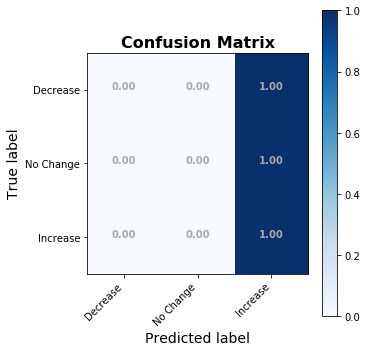

1246/1246 [==============================] - 1s 805us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[0. 0. 1.]


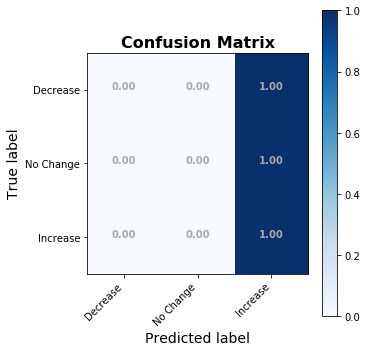

{'show_summary': False, 'verbose': 1, 'epochs': 2, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adam', 'activation': 'relu', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:24:08
Training model.
Epoch 1/2
1246/1246 [==============================] - 4s 3ms/step - loss: 2.4151 - acc: 0.3250
Epoch 2/2
623/623 [==============================] - 1s 883us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[0. 1. 0.]


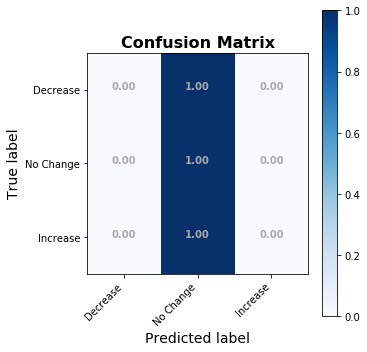

1246/1246 [==============================] - 1s 941us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[0. 1. 0.]


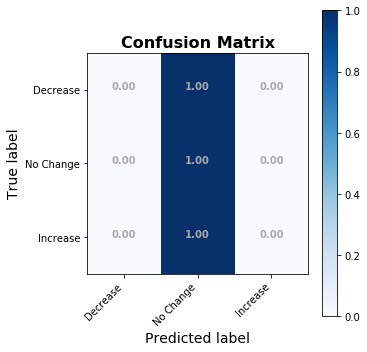

{'show_summary': False, 'verbose': 1, 'epochs': 2, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adam', 'activation': 'relu', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:24:19
Training model.
Epoch 1/2
1246/1246 [==============================] - 4s 4ms/step - loss: 2.4195 - acc: 0.3291
Epoch 2/2
623/623 [==============================] - 1s 955us/step
Mean Class Accuracy = 0.3394781369667825
Class Accuracy Values:
[0.94736842 0.         0.07106599]


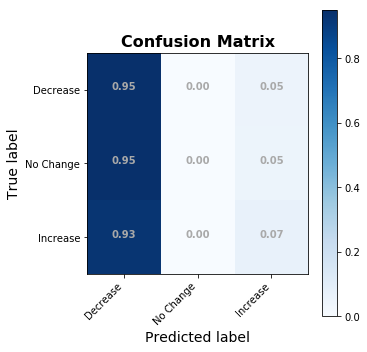

1246/1246 [==============================] - 1s 683us/step
Mean Class Accuracy = 0.3338649654439128
Class Accuracy Values:
[0.93939394 0.         0.06220096]


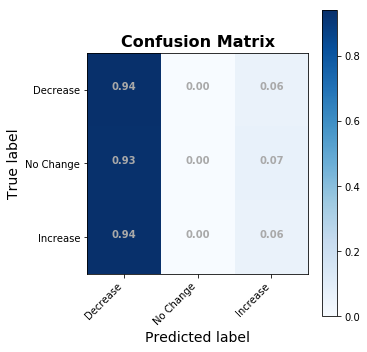

{'show_summary': False, 'verbose': 1, 'epochs': 2, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adam', 'activation': 'tanh', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:24:29
Training model.
Epoch 1/2
1246/1246 [==============================] - 4s 3ms/step - loss: 2.5023 - acc: 0.3266
Epoch 2/2
623/623 [==============================] - 1s 904us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[0. 0. 1.]


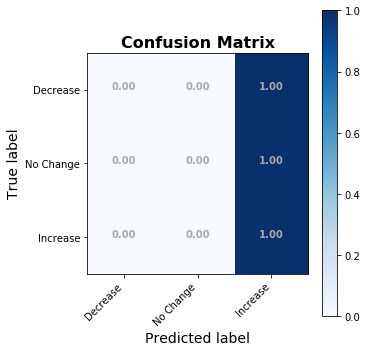

1246/1246 [==============================] - 1s 798us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[0. 0. 1.]


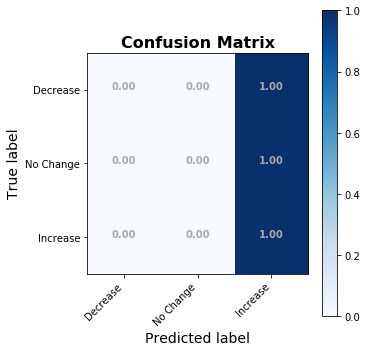

{'show_summary': False, 'verbose': 1, 'epochs': 2, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adam', 'activation': 'tanh', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:24:40
Training model.
Epoch 1/2
1246/1246 [==============================] - 5s 4ms/step - loss: 2.5169 - acc: 0.3291
Epoch 2/2
623/623 [==============================] - 1s 1ms/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[0. 1. 0.]


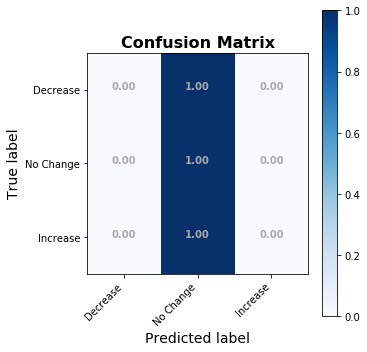

1246/1246 [==============================] - 1s 966us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[0. 1. 0.]


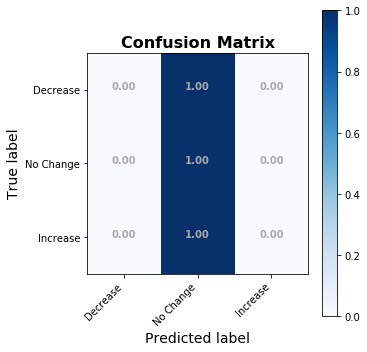

{'show_summary': False, 'verbose': 1, 'epochs': 2, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adam', 'activation': 'tanh', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:24:52
Training model.
Epoch 1/2
1246/1246 [==============================] - 5s 4ms/step - loss: 2.5016 - acc: 0.3258
Epoch 2/2
623/623 [==============================] - 1s 1ms/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


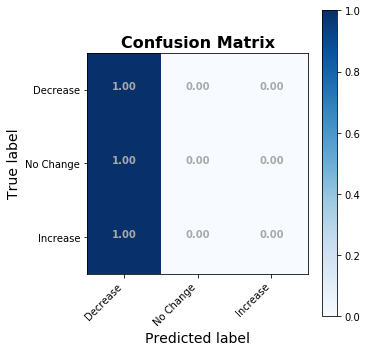

1246/1246 [==============================] - 1s 743us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


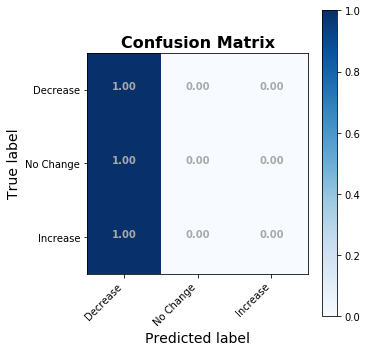

{'show_summary': False, 'verbose': 1, 'epochs': 2, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adam', 'activation': 'relu', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:25:03
Training model.
Epoch 1/2
1869/1869 [==============================] - 6s 3ms/step - loss: 2.2599 - acc: 0.3328
Epoch 2/2
1869/1869 [==============================] - 5s 3ms/step - loss: 1.4303 - acc: 0.3387
{'activation': 'relu', 'dropout': 0.2, 'epochs': 2, 'filter_size': 2, 'n_filters': 100, 'optimizer': 'adam'}
Email sent!


In [20]:
## Load email login credentials from file
my_pwd = EncryptedPassword(from_file=True)

## Fit Grid 
grid_result = grid.fit(X_train, y_train)

## Save and print best parameters
best_params = grid_result.best_params_
print(best_params)


## Send Email with completion time and best parameters found. 

##Construct mesage
time_completed = pd.datetime.now()
fmt = '%m/%d%Y-a%T'
msg = f"GridSearch Completed at {time_completed.strftime(fmt)}\n GridSearchResults:\n{best_params}"

# Send email
email_notification(password_obj=my_pwd,msg=msg)

## EXAMPLE USAGE AS A FUNCTION

- Encompasses the process used above into 1 function

In [21]:
## Define function to take the build function, parameter grid, and it will handle the logistics 
def fit_gridsearch(build_fn,parameter_grid,X_train,y_train,score_fn=None,verbose=1,
                   send_email=False,encrypted_password=None):
    """Builds a Keras model from build_fn, then wraps it in KerasClassifier 
    for use with sklearn's GridSearchCV. Can score GridSearch with built-in 
    metric from sklearn, or can pass a custom functions to be used with make_scorer().
    Upon completion, emails best parameters to gmail account. 
    
    Args:
        build_fn (func): Build function for model with parameters to tune as arguments.
        parameter_grid (dict): Dict of build_fn parameters (keys) and lists of parameters (values)
        X_train, y_train (numpy array): training dataset
        score_fn (func or str): Scoring function to use with GridSearchCV. 
            - For builtin sklearn metrics, pass their name as a string.
                - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
            - For custom function, pass function itself. Function must accept, y_true,y_pred
                and must return a value to maximize. 
            - Default(None)=ji.my_custom_scorer().
            
    Returns:
        model: (KerasClassifier) The return value. True for success, False otherwise.
        results
    """
    from keras.wrappers.scikit_learn import KerasClassifier#, KerasRegressor
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import make_scorer
    import pandas as pd
    
    import functions_combined_BEST as ji
    import bs_ds as bs
    

    ## Wrap create_model with KerasClassifier
    neural_network = KerasClassifier(build_fn=build_fn,verbose=verbose)
    
    
    ## Specify score_functin
    import types
    if score_fn is None:
        score_func = make_scorer(ji.my_custom_scorer)
    elif isinstance(score_fn, types.FunctionType):
        score_func = make_scorer(score_fn)
    elif isinstance(score_fn, str):
        score_func =  score_fn
        
    ## Run GridSearch
    grid = GridSearchCV(estimator=neural_network,param_grid=parameter_grid, 
                        scoring=score_func)

    ## Start Timer
    tune_clock = bs.Clock()
    tune_clock.tic()
    
    ## Fit GridSearch
    grid_result = grid.fit(X_train, y_train)
    tune_clock.toc()

    ## Print Best Params
    best_params = grid_result.best_params_
    print(best_params)

    
    ## Send Email with completion time and best parameters found. 
    if send_email:
        # get current time 
        time_completed = pd.datetime.now()
        fmt = '%m/%d%Y-%T' # time display format
        
        ## Compose message with time and best params
        msg = f"GridSearch Completed at {time_completed.strftime(fmt)}\n GridSearchResults:\n{best_params}"
        email_notification(password_obj=encrypted_password, msg=msg)
    
    return grid_result

--- CLOCK STARTED @:    10/03/19 - 09:25:17 PM --- 
{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'relu', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:25:17
Training model.
Epoch 1/10
1246/1246 [==============================] - 4s 3ms/step - loss: 2.4119 - acc: 0.3170A: 1s - loss: 2.5830
Epoch 2/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.7051 - acc: 0.3218
Epoch 3/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.3684 - acc: 0.3355A: 2s -
Epoch 4/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.2099 - acc: 0.3242
Epoch 5/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.1392 - acc: 0.3266
Epoch 6/10
1246/

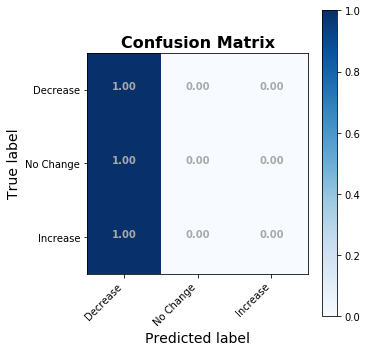

1246/1246 [==============================] - 1s 725us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


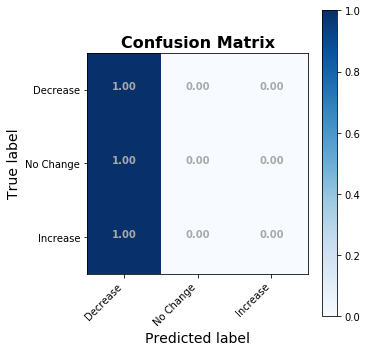

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'relu', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:25:54
Training model.
Epoch 1/10
1246/1246 [==============================] - 4s 4ms/step - loss: 2.3879 - acc: 0.3226
Epoch 2/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.6755 - acc: 0.3226
Epoch 3/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.3456 - acc: 0.3250
Epoch 4/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.1952 - acc: 0.3226
Epoch 5/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.1317 - acc: 0.3258
Epoch 6/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1091 - acc: 0.343

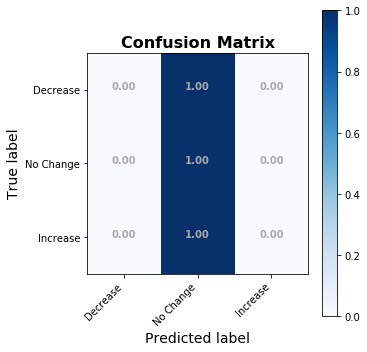

1246/1246 [==============================] - 1s 700us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[0. 1. 0.]


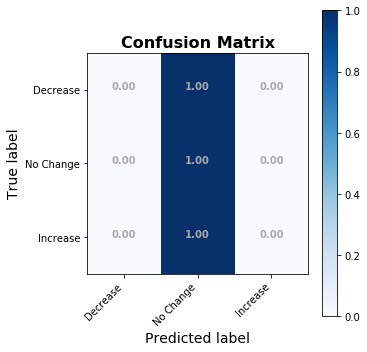

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'relu', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:26:33
Training model.
Epoch 1/10
1246/1246 [==============================] - 5s 4ms/step - loss: 2.4158 - acc: 0.3539
Epoch 2/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.7128 - acc: 0.3347A: 1s - loss:
Epoch 3/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.3758 - acc: 0.3234
Epoch 4/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.2154 - acc: 0.3218
Epoch 5/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.1419 - acc: 0.3563
Epoch 6/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.1136

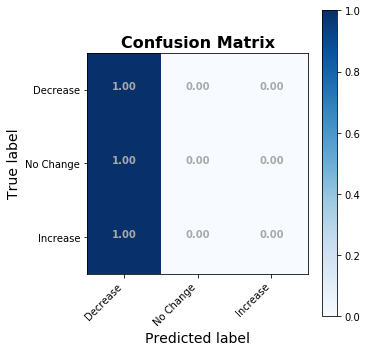

1246/1246 [==============================] - 1s 758us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


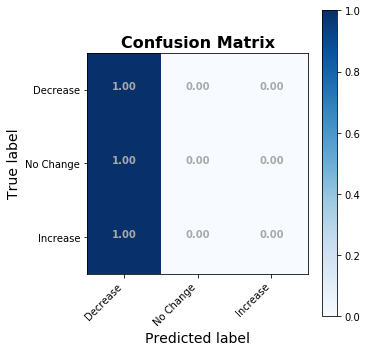

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'relu', 'filter_size': 4, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:27:11
Training model.
Epoch 1/10
1246/1246 [==============================] - 5s 4ms/step - loss: 1.9979 - acc: 0.3451
Epoch 2/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.4788 - acc: 0.3266
Epoch 3/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.2529 - acc: 0.3363
Epoch 4/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.1550 - acc: 0.3339
Epoch 5/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.1170 - acc: 0.3427A: 1s - los
Epoch 6/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.1034 -

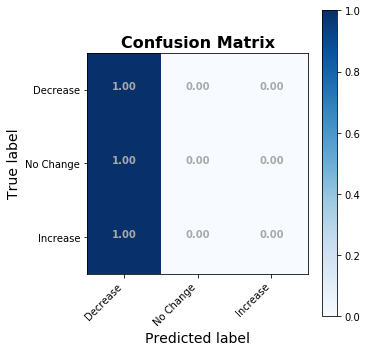

1246/1246 [==============================] - 1s 800us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


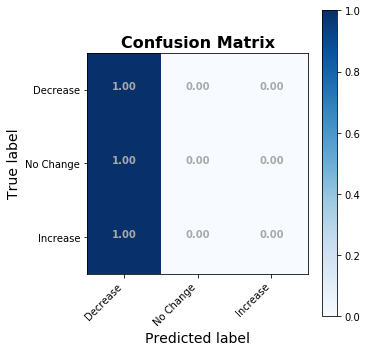

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'relu', 'filter_size': 4, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:27:50
Training model.
Epoch 1/10
1246/1246 [==============================] - 5s 4ms/step - loss: 1.9836 - acc: 0.3210
Epoch 2/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.4570 - acc: 0.3283
Epoch 3/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.2356 - acc: 0.3315
Epoch 4/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1460 - acc: 0.3323
Epoch 5/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1128 - acc: 0.3307A
Epoch 6/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1023 - acc: 0.33

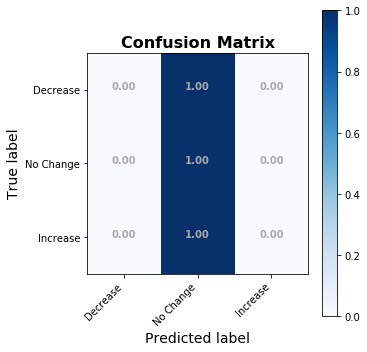

1246/1246 [==============================] - 1s 745us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[0. 1. 0.]


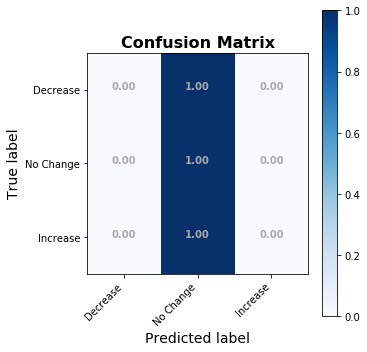

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'relu', 'filter_size': 4, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:28:31
Training model.
Epoch 1/10
1246/1246 [==============================] - 5s 4ms/step - loss: 2.0031 - acc: 0.3315
Epoch 2/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.4914 - acc: 0.3234
Epoch 3/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.2613 - acc: 0.3443
Epoch 4/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.1600 - acc: 0.3395
Epoch 5/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.1187 - acc: 0.3379
Epoch 6/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.1041 - acc: 0.341

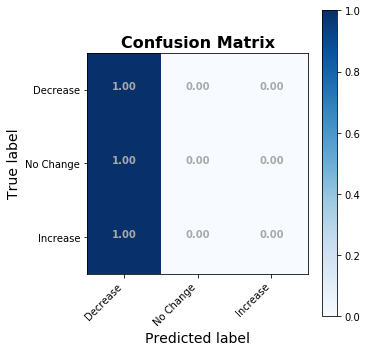

1246/1246 [==============================] - 1s 840us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


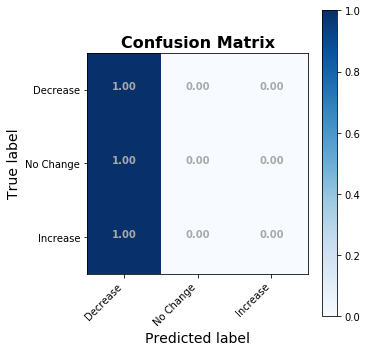

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'tanh', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:29:11
Training model.
Epoch 1/10
1246/1246 [==============================] - 6s 4ms/step - loss: 2.5027 - acc: 0.3363
Epoch 2/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.8542 - acc: 0.3411
Epoch 3/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.4978 - acc: 0.3170
Epoch 4/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.2959 - acc: 0.3242
Epoch 5/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1848 - acc: 0.3339
Epoch 6/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1312 - acc: 0.329

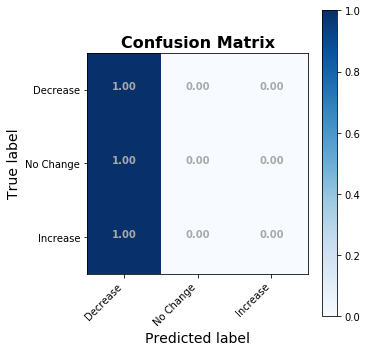

1246/1246 [==============================] - 1s 867us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


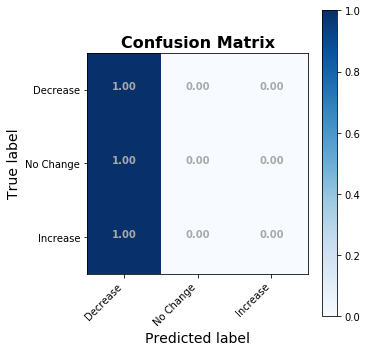

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'tanh', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:29:56
Training model.
Epoch 1/10
1246/1246 [==============================] - 6s 5ms/step - loss: 2.4879 - acc: 0.3323
Epoch 2/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.8360 - acc: 0.3130
Epoch 3/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.4816 - acc: 0.3226
Epoch 4/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.2856 - acc: 0.3315
Epoch 5/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1781 - acc: 0.3483
Epoch 6/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1287 - acc: 0.340

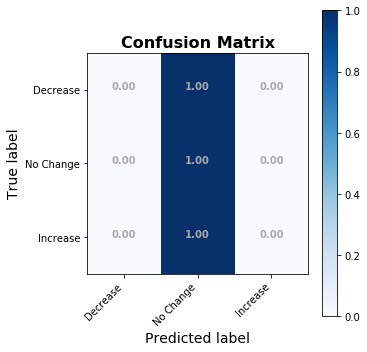

1246/1246 [==============================] - 1s 810us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[0. 1. 0.]


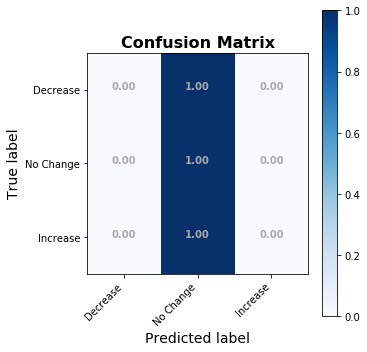

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'tanh', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:30:41
Training model.
Epoch 1/10
1246/1246 [==============================] - 5s 4ms/step - loss: 2.4485 - acc: 0.3467
Epoch 2/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.7823 - acc: 0.3202
Epoch 3/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.4367 - acc: 0.3315
Epoch 4/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.2519 - acc: 0.3475
Epoch 5/10
1246/1246 [==============================] - 4s 4ms/step - loss: 1.1606 - acc: 0.3307
Epoch 6/10
1246/1246 [==============================] - 4s 4ms/step - loss: 1.1199 - acc: 0.331

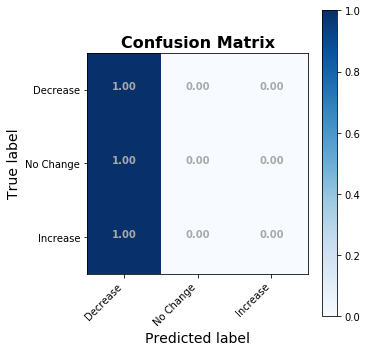

1246/1246 [==============================] - 1s 826us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


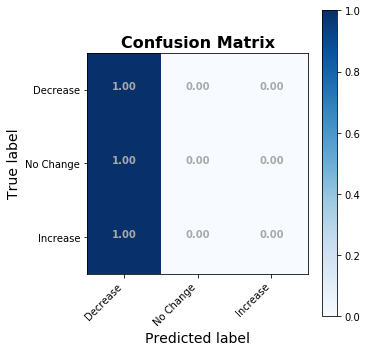

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'tanh', 'filter_size': 4, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:31:27
Training model.
Epoch 1/10
1246/1246 [==============================] - 5s 4ms/step - loss: 2.0255 - acc: 0.3307
Epoch 2/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.5355 - acc: 0.3395
Epoch 3/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.3000 - acc: 0.3403
Epoch 4/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1850 - acc: 0.3323
Epoch 5/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1310 - acc: 0.3299
Epoch 6/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1092 - acc: 0.324

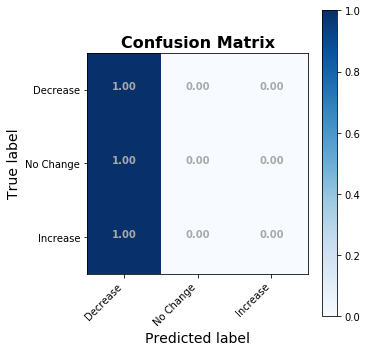

1246/1246 [==============================] - 1s 890us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


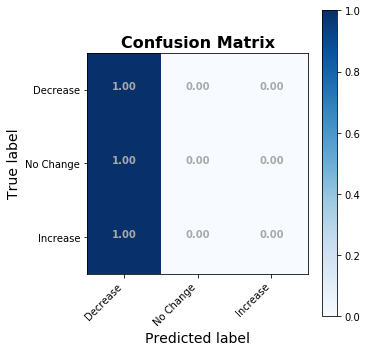

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'tanh', 'filter_size': 4, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:32:11
Training model.
Epoch 1/10
1246/1246 [==============================] - 7s 6ms/step - loss: 2.0478 - acc: 0.3467
Epoch 2/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.5564 - acc: 0.3387
Epoch 3/10
1246/1246 [==============================] - 5s 4ms/step - loss: 1.3158 - acc: 0.3250
Epoch 4/10
1246/1246 [==============================] - 4s 4ms/step - loss: 1.1949 - acc: 0.3347
Epoch 5/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1340 - acc: 0.3499
Epoch 6/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1113 - acc: 0.334

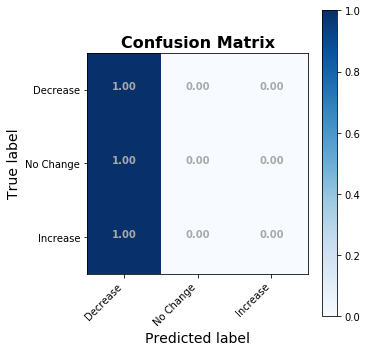

1246/1246 [==============================] - 1s 851us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


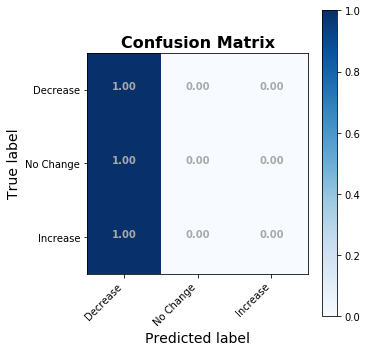

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'tanh', 'filter_size': 4, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:32:59
Training model.
Epoch 1/10
1246/1246 [==============================] - 6s 4ms/step - loss: 2.0372 - acc: 0.3138
Epoch 2/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.5483 - acc: 0.3162
Epoch 3/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.3102 - acc: 0.3379
Epoch 4/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1913 - acc: 0.3339
Epoch 5/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1346 - acc: 0.3563
Epoch 6/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1104 - acc: 0.335

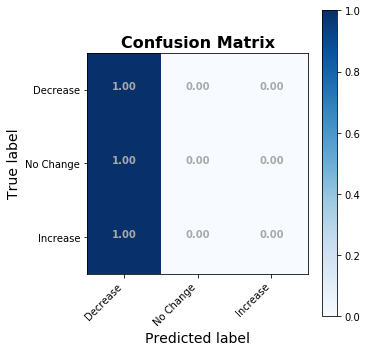

1246/1246 [==============================] - 1s 860us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


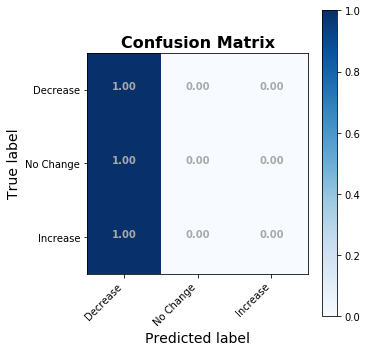

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'linear', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:33:43
Training model.
Epoch 1/10
1246/1246 [==============================] - 6s 5ms/step - loss: 2.5631 - acc: 0.3411
Epoch 2/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.9413 - acc: 0.3186
Epoch 3/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.5858 - acc: 0.3106
Epoch 4/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.3631 - acc: 0.3218
Epoch 5/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.2290 - acc: 0.3355A: 
Epoch 6/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1550 - acc: 

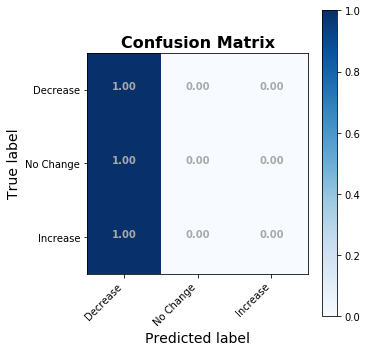

1246/1246 [==============================] - 1s 823us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


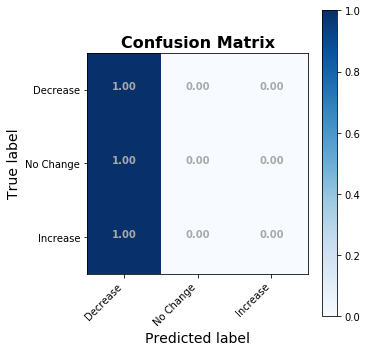

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'linear', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:34:28
Training model.
Epoch 1/10
1246/1246 [==============================] - 6s 5ms/step - loss: 2.4696 - acc: 0.3315
Epoch 2/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.8130 - acc: 0.3596A: 2s - lo
Epoch 3/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.4671 - acc: 0.3459
Epoch 4/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.2741 - acc: 0.3194
Epoch 5/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.1723 - acc: 0.3274
Epoch 6/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.1256 

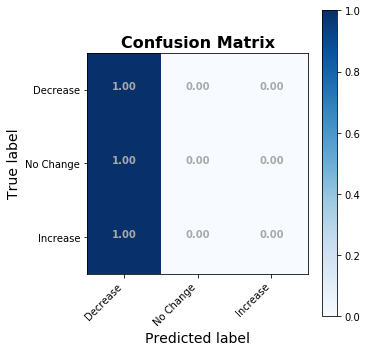

1246/1246 [==============================] - 1s 801us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


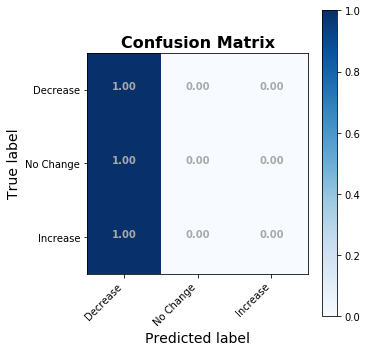

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'linear', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:35:09
Training model.
Epoch 1/10
1246/1246 [==============================] - 6s 5ms/step - loss: 2.5042 - acc: 0.3218
Epoch 2/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.8550 - acc: 0.3242
Epoch 3/10
1246/1246 [==============================] - 3s 3ms/step - loss: 1.4983 - acc: 0.3355
Epoch 4/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.2990 - acc: 0.3283
Epoch 5/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1880 - acc: 0.3419A: 0s - loss: 1.1931 - acc: 
Epoch 6/10
1246/1246 [==============================] - 4s 3ms/st

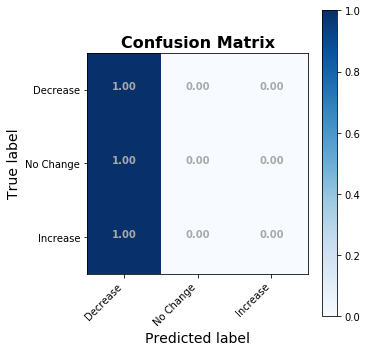

1246/1246 [==============================] - 1s 800us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


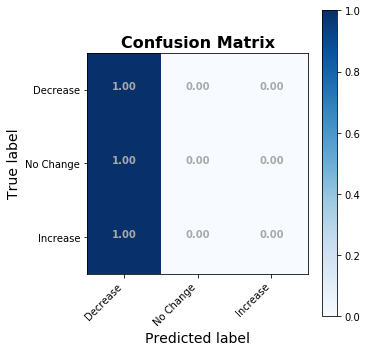

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'linear', 'filter_size': 4, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:35:50
Training model.
Epoch 1/10
1246/1246 [==============================] - 6s 5ms/step - loss: 2.0729 - acc: 0.3307
Epoch 2/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.5839 - acc: 0.3234
Epoch 3/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.3420 - acc: 0.3451
Epoch 4/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.2136 - acc: 0.3363
Epoch 5/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1454 - acc: 0.3403
Epoch 6/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1148 - acc: 0.3

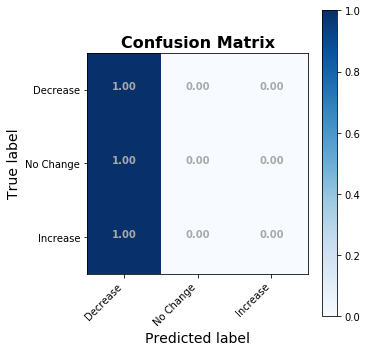

1246/1246 [==============================] - 1s 983us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


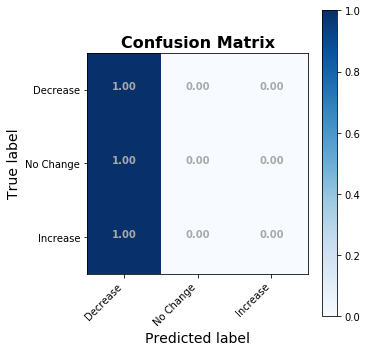

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'linear', 'filter_size': 4, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:36:35
Training model.
Epoch 1/10
1246/1246 [==============================] - 7s 6ms/step - loss: 2.0635 - acc: 0.3291
Epoch 2/10
1246/1246 [==============================] - 5s 4ms/step - loss: 1.5931 - acc: 0.3226
Epoch 3/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.3518 - acc: 0.3283
Epoch 4/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.2215 - acc: 0.3507
Epoch 5/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1523 - acc: 0.3331
Epoch 6/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1184 - acc: 0.3

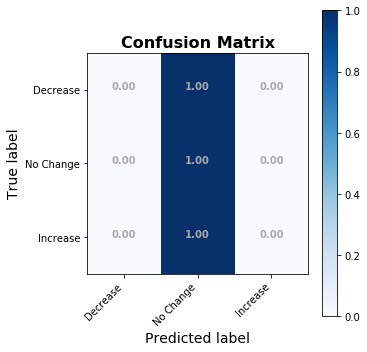

1246/1246 [==============================] - 1s 877us/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[0. 1. 0.]


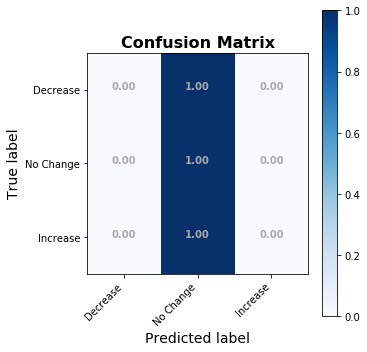

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'linear', 'filter_size': 4, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:37:21
Training model.
Epoch 1/10
1246/1246 [==============================] - 6s 5ms/step - loss: 2.0624 - acc: 0.3234
Epoch 2/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.5917 - acc: 0.3371
Epoch 3/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.3505 - acc: 0.3258
Epoch 4/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.2194 - acc: 0.3355
Epoch 5/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1500 - acc: 0.3242
Epoch 6/10
1246/1246 [==============================] - 4s 3ms/step - loss: 1.1171 - acc: 0.3

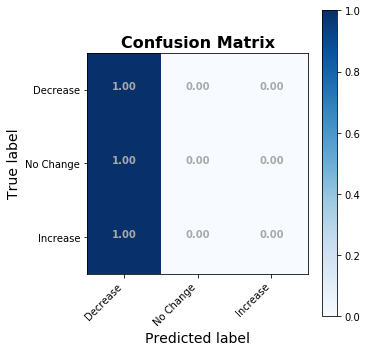

1246/1246 [==============================] - 1s 1ms/step
Mean Class Accuracy = 0.3333333333333333
Class Accuracy Values:
[1. 0. 0.]


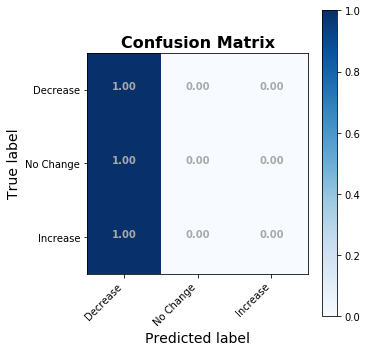

{'show_summary': False, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'relu', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:38:07
Training model.
Epoch 1/10
1869/1869 [==============================] - 9s 5ms/step - loss: 2.2141 - acc: 0.3376
Epoch 2/10
1869/1869 [==============================] - 6s 3ms/step - loss: 1.4380 - acc: 0.3264
Epoch 3/10
1869/1869 [==============================] - 7s 4ms/step - loss: 1.1876 - acc: 0.3381
Epoch 4/10
1869/1869 [==============================] - 6s 3ms/step - loss: 1.1167 - acc: 0.3205
Epoch 5/10
1869/1869 [==============================] - 6s 3ms/step - loss: 1.1021 - acc: 0.3301
Epoch 6/10
1869/1869 [==============================] - 6s 3ms/step - loss: 1.1008 - acc: 0.320

Lap #,Start Time,Duration,Label
TOTAL,10/03/19 - 09:25:17 PM,"13 min, 57.120 sec",--


{'activation': 'relu', 'dropout': 0.2, 'epochs': 10, 'filter_size': 2, 'n_filters': 100, 'optimizer': 'adadelta'}
Email sent!


In [22]:
# Create HyperParaemeter Space
params_to_search ={'filter_size':[2,4],#,6],
                   'activation':['relu','tanh','linear'],
                   'n_filters':[100],#,200],#,300,400],
                  'dropout':[0.2],#0.4],
                  'optimizer':['adadelta'],#'adam','rmsprop','
                'epochs':[10]}

## Load login credentials from file
my_pwd = EncryptedPassword(from_file=True)

## Fit GridSearch
grid_result = fit_gridsearch(build_fn=create_model,parameter_grid=params_to_search,
                            X_train=X_train, y_train=y_train, score_fn=my_custom_scorer,
                             send_email=True, encrypted_password=my_pwd)

In [23]:
best_params = grid_result.best_params_
print(best_params)

{'activation': 'relu', 'dropout': 0.2, 'epochs': 10, 'filter_size': 2, 'n_filters': 100, 'optimizer': 'adadelta'}


## Companion/Follow-up Function for Running Best Params from `fit_gridsearch`
```python
## Fit GridSearch
grid_result = fit_gridsearch(build_fn=create_model,parameter_grid=params_to_search,
                            X_train=X_train, y_train=y_train, score_fn=my_custom_scorer,
                             send_email=True, encrypted_password=my_pwd)
## save dict with best params
best_params = grid_result.best_params_

### NOW CREATE A STANDALONE MODEL AND RUN WITH BEST PARAMS
## Create Model using best parameters
model = create_model(**best_params)

## Run companion function below
model, results = fit_and_eval_model(model, X_train, X_test, X_val, 
                                    y_train, y_test, y_val,**best_params)
```

In [24]:
## DEFINE FUNCTION FOR FITTING AND EVALUATING SINGLE MODELS (Not GridSearch)
def fit_and_eval_model(model, X_train, X_test, X_val, y_train, y_test, y_val,
                      epochs = 10, batch_size=100,verbose=1,**kwargs):
    """Fits Kera's model with X_train, y_train data, using (X_val, y_val) for validation_data.
    - Then evaluates model with training/test data
    - Plots Keras Training History
    - Plots Confusion Matrix
    """
    if 'epochs' in kwargs:
        epochs=kwargs['epochs']
        
    if 'batch_size' in kwargs:
        batch_size=kwargs['batch_size']
        
        
    clock = bs.Clock()
    clock.tic()
    dashes = '---'*20
    print(f"{dashes}\n\tFITTING MODEL:\n{dashes}")
    
    
    history = model.fit(X_train, y_train, 
                          epochs=epochs,
                          verbose=verbose, 
                          validation_data=(X_val,y_val),
                          batch_size=batch_size)

    clock.toc()

    df_report,fig=ji.evaluate_classification_model(model=model,history=history,
                                                       X_train=X_train, X_test=X_test,
                                                       y_train=y_train, y_test=y_test, 
                                                       binary_classes=False,
                                                       conf_matrix_classes=['Decrease','No Change','Increase'])
    return model, df_report

{'show_summary': True, 'verbose': 1, 'epochs': 10, 'batch_size': 100, 'l2_lr': 0.01, 'dropout': 0.2, 'optimizer': 'adadelta', 'activation': 'relu', 'filter_size': 2, 'n_filters': 100, 'trainable': False, 'embedding_layer': <keras.layers.embeddings.Embedding object at 0x0000015324019CC0>}



------------------------------------------------------------------------------------------
10/03/2019-21:39:16
Training model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 33)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 33, 300)           1404600   
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 100, 299)          6700      
_________________________________________________________________
dropout_79 (Dropout)         (None, 100, 299)        

None

--- CLOCK STARTED @:    10/03/19 - 09:39:16 PM --- 
------------------------------------------------------------
	FITTING MODEL:
------------------------------------------------------------
Train on 1869 samples, validate on 401 samples
Epoch 1/10
1869/1869 [==============================] - 10s 5ms/step - loss: 2.6115 - acc: 0.3355 - val_loss: 2.3006 - val_acc: 0.3392
Epoch 2/10
1869/1869 [==============================] - 6s 3ms/step - loss: 2.0946 - acc: 0.3317 - val_loss: 1.8844 - val_acc: 0.3566
Epoch 3/10
1869/1869 [==============================] - 6s 3ms/step - loss: 1.7469 - acc: 0.3440 - val_loss: 1.6070 - val_acc: 0.3392
Epoch 4/10
1869/1869 [==============================] - 7s 4ms/step - loss: 1.5160 - acc: 0.3264 - val_loss: 1.4239 - val_acc: 0.3217
Epoch 5/10
1869/1869 [==============================] - 7s 4ms/step - loss: 1.3636 - acc: 0.3226 - val_loss: 1.3037 - val_acc: 0.3217
Epoch 6/10
1869/1869 [==============================] - 6s 3ms/step - loss: 1.2636 - acc: 0.

Lap #,Start Time,Duration,Label
TOTAL,10/03/19 - 09:39:16 PM,"1 min, 9.097 sec",--


------------------------------------------------------------------------------------------
	TRAINING HISTORY:
------------------------------------------------------------------------------------------


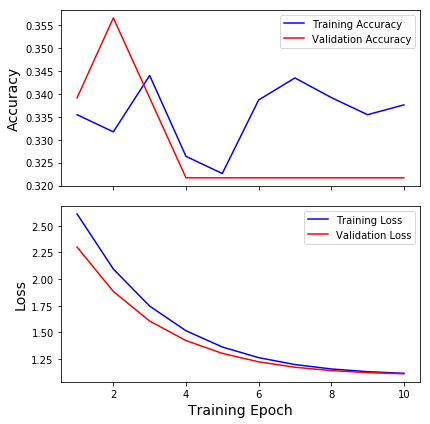



------------------------------------------------------------------------------------------
	EVALUATE MODEL:
------------------------------------------------------------------------------------------

- Evaluating Training Data:
1869/1869 [==============================] - 2s 1ms/step
    - Accuracy:0.3414
    - Loss:1.1113

- Evaluating Test Data:
400/400 [==============================] - 0s 1ms/step
    - Accuracy:0.3225
    - Loss:1.1121

------------------------------------------------------------------------------------------
	CLASSIFICATION REPORT:
------------------------------------------------------------------------------------------


C:\Users\james\Anaconda3\envs\learn-env-ext\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\james\Anaconda3\envs\learn-env-ext\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\james\Anaconda3\envs\learn-env-ext\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\james\Anaconda3\envs\learn-env-ext\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in label

,precision,recall,f1-score,support
0,0.3225,1,0.4877,129
1,0,0,0,134
2,0,0,0,137
micro avg,0.3225,0.3225,0.3225,400
macro avg,0.1075,0.3333,0.1626,400
weighted avg,0.104,0.3225,0.1573,400


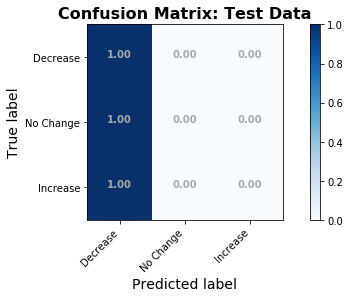

C:\Users\james\Anaconda3\envs\learn-env-ext\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


In [25]:
model = create_model(**best_params, show_summary=True)

## Run companion function below
model, results = fit_and_eval_model(model, X_train, X_test, X_val, 
                                    y_train, y_test, y_val,**best_params)